In [18]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from tensorflow import keras

# 1 - Data

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
print("Tweet:\n",train["text"][0], "\n\nReal?:\n",train["target"][0])

Tweet:
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

Real?:
 1


In [4]:
print("Tweet:\n",train["text"][15], "\n\nReal?:\n",train["target"][15])

Tweet:
 What's up man? 

Real?:
 0


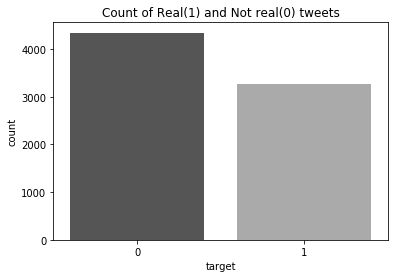

In [5]:
sns.countplot(train["target"], palette="gray")
plt.title("Count of Real(1) and Not real(0) tweets")
plt.show()

# 2 - Pre-processing

## 2.1 - Clean tweets

- Clean tweet (delete https, punctuation, etc)
- Tokenize words ("hello i'm a string") --> ["hello","i'm","a","string"]
- Delete stopwords (in, at, the, ... )
- Stemming (changing, change, changed --> chang)

In [6]:
def preprocess_tweet(tweet):
    
    '''Cleaning tweet'''
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*', ' ', tweet)
    tweet2 = re.sub(r'#', ' ', tweet2)
    tweet2 = re.sub(r'\$\w*', ' ', tweet2)
    tweet2 = re.sub(r'^RT[\s]+', ' ', tweet2)
    table = str.maketrans("", "", string.punctuation)
    tweet2 = tweet2.translate(table)

    '''Tokenize'''
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet2)

    '''Stop words'''
    stopwords_english = stopwords.words('english')
    tweet_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english:
            tweet_clean.append(word)

    '''Stemming'''
    stemmer = PorterStemmer()
    tweet_stemmed = []
    for word in tweet_clean:
        stem_word = stemmer.stem(word)
        tweet_stemmed.append(stem_word)

    return tweet_stemmed

In [34]:
train_processed = pd.DataFrame(index = range(len(train)),columns = ["id","text","target"])
test_processed = pd.DataFrame(index = range(len(test)),columns = ["id","text"])

for i in range(len(train)):
    train_processed["id"][i] = train["id"][i]
    train_processed["text"][i] = preprocess_tweet(train["text"][i])
    train_processed["target"][i] = train["target"][i]

for i in range(len(test)):
    test_processed["id"][i] = test["id"][i]
    test_processed["text"][i] = preprocess_tweet(test["text"][i])

In [8]:
print("Before processing\n\n",train["text"][511],"\n\nAfter processing:\n")
print(train_processed["text"][511])

Before processing

 Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/ETg0prBP4G 

After processing:

['christian', 'attack', 'muslim', 'templ', 'mount', 'wave', 'isra', 'flag', 'via', 'pamela', 'geller']


In [9]:
words_true = []
words_false = []

for tweet in train_processed[train_processed["target"]==1]["text"]:
    words_true += tweet
    
for tweet in train_processed[train_processed["target"]==0]["text"]:
    words_false += tweet

real_cloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(' '.join(words_true))
false_cloud = WordCloud(stopwords=STOPWORDS,background_color="white").generate(' '.join(words_false))

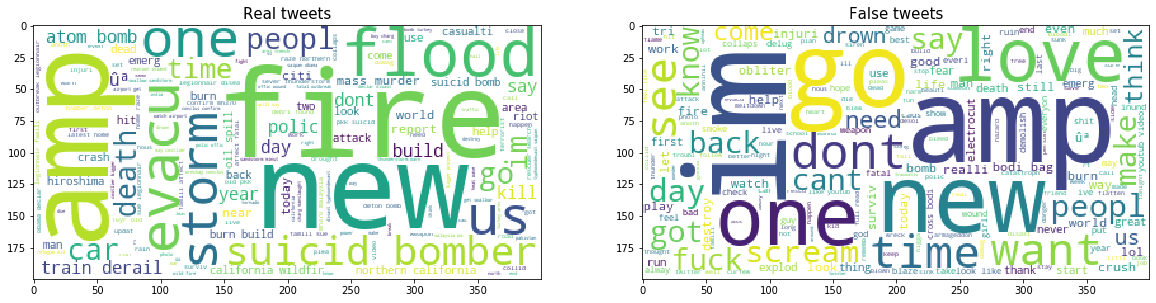

In [10]:
f, (ax1,ax2) = plt.subplots(ncols = 2, figsize=(20,15))

ax1.imshow(real_cloud)
ax2.imshow(false_cloud)

ax1.set_title("Real tweets", fontsize = 15)
ax2.set_title("False tweets", fontsize = 15)

plt.show()

## 2.2 Create vocabulary, counters, index

- Vocabulary: dictionary with every word and its count.
- Vocab_size: the number of word present in the vocabulary.
- Tweet_max_length: number of characteres for each tweet. (if it less, 0 will be added)

In [27]:
all_words = []

for tweet in train_processed["text"]:
    all_words += tweet
    
vocabulary = Counter(all_words)
vocab_size = len(vocabulary)
tweet_max_length = 25

In [12]:
vocab_size

14112

Two dictionaries, one for mapping words to index and the other for map index to words

In [13]:
word2Index = {}
Index2word = {}

for i,word in enumerate(vocabulary.keys()):
    word2Index[word] = i
    Index2word[i] = word

In [14]:
Index2word[999] , word2Index["peninsula"]

('peninsula', 999)

## 2.3 - Transform string to numbers

In order to put the tweets into the neural network, we need to transform each word to a number (in this case, the index number of the word from the vocabulary)

In [15]:
print(train_processed["text"][100])
print("\nTransformed---->")
list(map(word2Index.get, train_processed["text"][100]))

['norwaymfa', 'bahrain', 'polic', 'previous', 'die', 'road', 'accid', 'kill', 'explos']

Transformed---->


[522, 523, 174, 524, 71, 525, 337, 526, 527]

In [35]:
for i,tweet in enumerate(train_processed["text"]):
    train_processed["text"][i] = list(map(word2Index.get, tweet))
    
for i,tweet in enumerate(test_processed["text"]):
    test_processed["text"][i] = list(map(word2Index.get, tweet))

In [53]:
for i,tweet in enumerate(test_processed["text"]):
    test_processed["text"][i] = [0 if v is None else v for v in test_processed["text"][i]]

Also, we need the same lenght of index for each text. So we fill those who has less than 30 words with 0.

In [41]:
print(train_processed["text"][100])
print("\nPadded\n")

print(keras.preprocessing.sequence.pad_sequences(train_processed["text"], maxlen=tweet_max_length, 
                                           padding="post")[100].tolist())

[522, 523, 174, 524, 71, 525, 337, 526, 527]

Padded

[522, 523, 174, 524, 71, 525, 337, 526, 527, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [60]:
padded_train_tweets = keras.preprocessing.sequence.pad_sequences(train_processed["text"],
                                                                 maxlen=tweet_max_length,
                                                                 padding="post")

padded_test_tweets = keras.preprocessing.sequence.pad_sequences(test_processed["text"],
                                                                 maxlen=tweet_max_length,
                                                                 padding="post")

In [66]:
padded_train_tweets.shape, padded_test_tweets.shape, 

((7613, 25), (3263, 25))

Now we have 7613 train samples with 25 features each.
The data is ready to train a neural network

# 3. RNN

## 3.1 - Simple LSTM RNN 

In [88]:
model = keras.models.Sequential()

model.add(keras.layers.Embedding(input_dim = vocab_size, 
                                 output_dim = 64, 
                                 input_length=tweet_max_length))

model.add(keras.layers.LSTM(units = 64,
                            dropout = 0.2))

model.add(keras.layers.Dense(units = 1, 
                             activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 25, 64)            903168    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 936,257
Trainable params: 936,257
Non-trainable params: 0
_________________________________________________________________


In [89]:
hist = model.fit(x = padded_train_tweets,
                 y = train["target"], 
                 epochs = 10,
                 validation_split = 0.2)

Epoch 1/10
191/191 [==============================] - 8s 41ms/step - loss: 0.6837 - accuracy: 0.5696 - val_loss: 0.6923 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 7s 37ms/step - loss: 0.6309 - accuracy: 0.6289 - val_loss: 0.5677 - val_accuracy: 0.7597
Epoch 3/10
191/191 [==============================] - 7s 36ms/step - loss: 0.4085 - accuracy: 0.8263 - val_loss: 0.5015 - val_accuracy: 0.7446
Epoch 4/10
191/191 [==============================] - 7s 37ms/step - loss: 0.3226 - accuracy: 0.8700 - val_loss: 0.5238 - val_accuracy: 0.7551
Epoch 5/10
191/191 [==============================] - 7s 37ms/step - loss: 0.2597 - accuracy: 0.9041 - val_loss: 0.5788 - val_accuracy: 0.7341
Epoch 6/10
191/191 [==============================] - 7s 36ms/step - loss: 0.2150 - accuracy: 0.9210 - val_loss: 0.6341 - val_accuracy: 0.7177
Epoch 7/10
191/191 [==============================] - 7s 36ms/step - loss: 0.1785 - accuracy: 0.9388 - val_loss: 0.7081 - val_accuracy: 0.6980

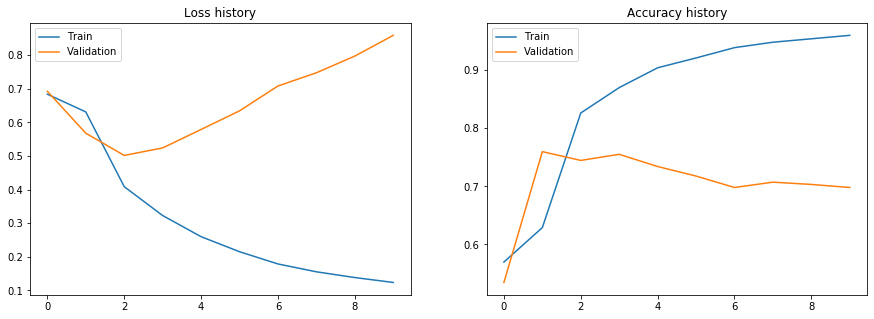

In [90]:
f, (ax1,ax2) = plt.subplots(figsize=(15,5), ncols = 2)

ax1.plot(hist.history["loss"],label = "Train")
ax1.plot(hist.history["val_loss"], label = "Validation")

ax2.plot(hist.history["accuracy"], label = "Train")
ax2.plot(hist.history["val_accuracy"], label = "Validation")

ax1.set_title("Loss history")
ax2.set_title("Accuracy history")

ax1.legend()
ax2.legend()

plt.show()

In [110]:
prediction = model.predict(padded_test_tweets)

submission = pd.DataFrame(index = range(len(prediction)) , columns = ["id","target"] )
submission["target"] = [1 if p>0.5 else 0 for p in prediction]
submission["id"] = test["id"]

submission.to_csv("predictions/simple_lstm_rnn.csv",
                  index=None)

The score of this model in the Kaggle competition is: $74.777\%$

## 3.2 Bidirectional LSTM

In [105]:
model2 = keras.models.Sequential()

model2.add(keras.layers.Embedding(input_dim = vocab_size, 
                                 output_dim = 64, 
                                 input_length=tweet_max_length))

model2.add(keras.layers.Bidirectional(keras.layers.LSTM(units = 64,
                                                        dropout = 0.2)))

model2.add(keras.layers.Dense(units = 1, 
                             activation="sigmoid"))

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics=["accuracy"])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 25, 64)            903168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 969,345
Trainable params: 969,345
Non-trainable params: 0
_________________________________________________________________


In [106]:
hist2 = model2.fit(x = padded_train_tweets,
                   y = train["target"],
                   epochs = 5,
                   batch_size=16,
                   validation_split = 0.2)

Epoch 1/5
381/381 [==============================] - 16s 42ms/step - loss: 0.6767 - accuracy: 0.5686 - val_loss: 0.6773 - val_accuracy: 0.5345
Epoch 2/5
381/381 [==============================] - 15s 40ms/step - loss: 0.5459 - accuracy: 0.7107 - val_loss: 0.4845 - val_accuracy: 0.7728
Epoch 3/5
381/381 [==============================] - 20s 51ms/step - loss: 0.3487 - accuracy: 0.8611 - val_loss: 0.5085 - val_accuracy: 0.7492
Epoch 4/5
381/381 [==============================] - 18s 48ms/step - loss: 0.2705 - accuracy: 0.8992 - val_loss: 0.5244 - val_accuracy: 0.7551
Epoch 5/5
381/381 [==============================] - 17s 45ms/step - loss: 0.2152 - accuracy: 0.9228 - val_loss: 0.5796 - val_accuracy: 0.7472


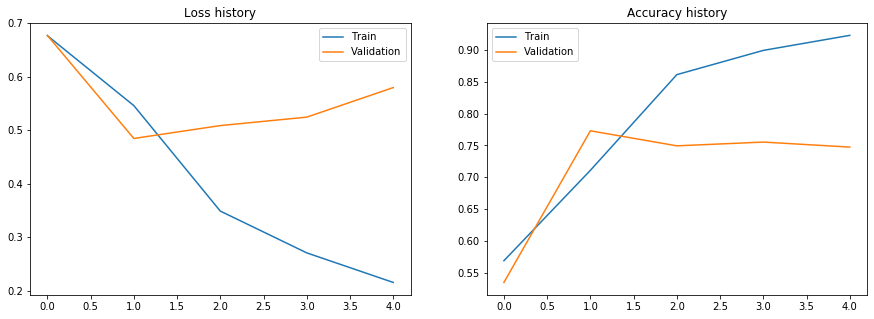

In [107]:
f, (ax1,ax2) = plt.subplots(figsize=(15,5), ncols = 2)

ax1.plot(hist2.history["loss"],label = "Train")
ax1.plot(hist2.history["val_loss"], label = "Validation")

ax2.plot(hist2.history["accuracy"], label = "Train")
ax2.plot(hist2.history["val_accuracy"], label = "Validation")

ax1.set_title("Loss history")
ax2.set_title("Accuracy history")

ax1.legend()
ax2.legend()

plt.show()

In [111]:
prediction2 = model2.predict(padded_test_tweets)

submission2 = pd.DataFrame(index = range(len(prediction2)) , columns = ["id","target"] )
submission2["target"] = [1 if p>0.5 else 0 for p in prediction2]
submission2["id"] = test["id"]

submission2.to_csv("bidirectional_lstm_rnn.csv",
                  index=None)


The score of this model in the Kaggle competition is: $77.168\%$